## Imports

In [3]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from skimage import io, transform, color
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from imgaug import augmenters as iaa
import imgaug.augmenters.flip as flip
from IPython.display import Image


## Mask Augmentation

The input to our video object segmention (VOS) network will be an image with four channels; red, green, blue, and mask (RGB-M).  The first three channels are just the image from the current frame.  The mask channel is the segmentation result from the previous image.  If we do not have access to fully label videos, but have single image/mask pairs, we can simulate a previous frames segmentation by augmenting the ground truth segmentation and passing it in as if it were the last frames image.

These augmentations will include:
 - Minor transformations to simluate perspective change
 - Major transforms to ensure that the masks are sometimes discarded
 - Empty masks so the network works well on the first frame and can classsify new segmentation regions
 - Blurring to simulate motion and uncertainty

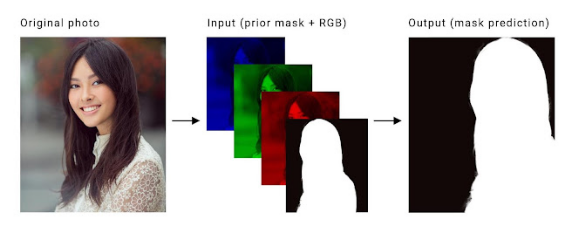

In [34]:
# Shows the RGB-M format
plt.imshow(plt.imread("figure1.jpg"))
plt.axis("off")
plt.rcParams['figure.figsize'] = [12, 12]

## Minor Transforms

The oringinal Google blog that proposed this idea suggested using an Affine transform to make slight changes to the mask, however Homographies can more realistically capture camera motion.  Two methods are included here, one that applies homographies using OpenCV's warpPerspective function and another that makes use imgaug's PerspectiveTransform function.

We can also do transformations besides perspective changes to simulate small motion between frames.  These include zooming and panning, which can be replicated by cropping the image.


In [12]:
# Uses imgaug library to to perform a minor perspective transform
def MinorTransformIA(img, lower=0.0, upper=0.1):
    persp = iaa.PerspectiveTransform(scale=(lower, upper), keep_size=True)
    return persp(image=img)

# Uses OpenCV to perform a random minor homography, thereby simulating a perspective shift
def MinorTransformCV(img):

    # Set up randomization fucntion
    randNormalOffset = lambda scale: np.random.normal() * scale
    
    # Get image dimensions
    if (len(img.shape) == 3):
        h,w,_ = img.shape # RGB
        border_val = (0.5, 0.5, 0.5)
    else:
        h,w = img.shape # Greyscale 
        border_val = (0.5)

    # Normalize image
    img = img / np.max(img)

    # Define point from (corners of the image)
    pts_src = np.array([[0, 0], 
                        [0, h], 
                        [w, h], 
                        [w, 0]])

    # Define points to map to (corners but slightly offset)
    s_w = int(w * 0.05)
    s_h = int(h * 0.05)
    pts_dst = np.array([[randNormalOffset(s_w), randNormalOffset(s_h)], 
                        [randNormalOffset(s_w), h + randNormalOffset(s_h)], 
                        [w + randNormalOffset(s_w), h + randNormalOffset(s_h)], 
                        [w + randNormalOffset(s_w), randNormalOffset(s_h)]])

    # Calculate homography H1
    H1, status = cv2.findHomography(pts_src, pts_dst)

    # Apply homography
    img_augmented = cv2.warpPerspective(img, H1, (w,h), borderMode=cv2.BORDER_CONSTANT, borderValue=border_val)

    return img_augmented



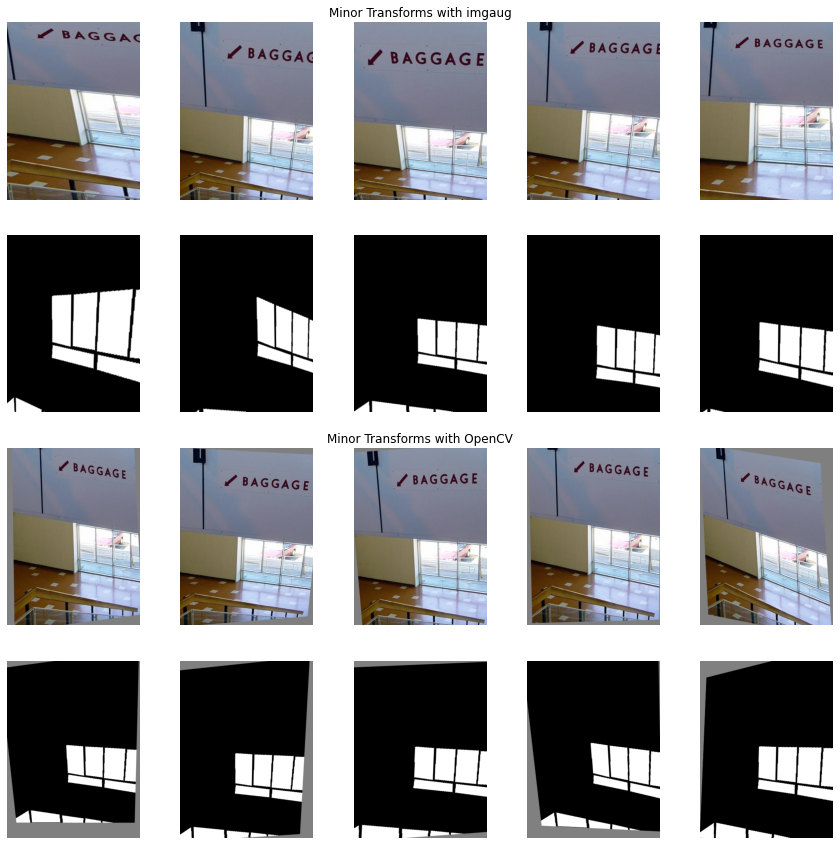

In [13]:
# Test the minor transformation functions

# Load a test image and corresponding mask
test_img_path = "test_image.jpg"
test_mask_path = "test_mask.png"
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_mask = cv2.imread(test_mask_path)
test_mask = test_mask[:,:,0]

# Define plots
fig, axs = plt.subplots(4, 5, figsize=(15,15))
axs[0,2].set_title('Minor Transforms with imgaug')
axs[2,2].set_title('Minor Transforms with OpenCV')

# Show five example transformations
for i in range(5):
    # Image Aug method
    axs[0,i].imshow(MinorTransformIA(test_img))
    axs[0,i].axis("off")
    axs[1,i].imshow(MinorTransformIA(test_mask), cmap='gray')
    axs[1,i].axis("off")

    # OpenCV method
    axs[2,i].imshow(MinorTransformCV(test_img))
    axs[2,i].axis("off")
    axs[3,i].imshow(MinorTransformCV(test_mask), cmap='gray')
    axs[3,i].axis("off")


In [14]:

def RandomZoomMask(img):
    zoom = iaa.Crop(percent=(0, 0.25)) # random crop
    return zoom(image=img)

def RandomZoomImage(img, mask, ref):
    zoom = iaa.Crop(percent=(0, 0.25)) # random crop
    zoom = zoom.to_deterministic()
    return zoom(image=img), zoom(image=mask), zoom(image=ref)

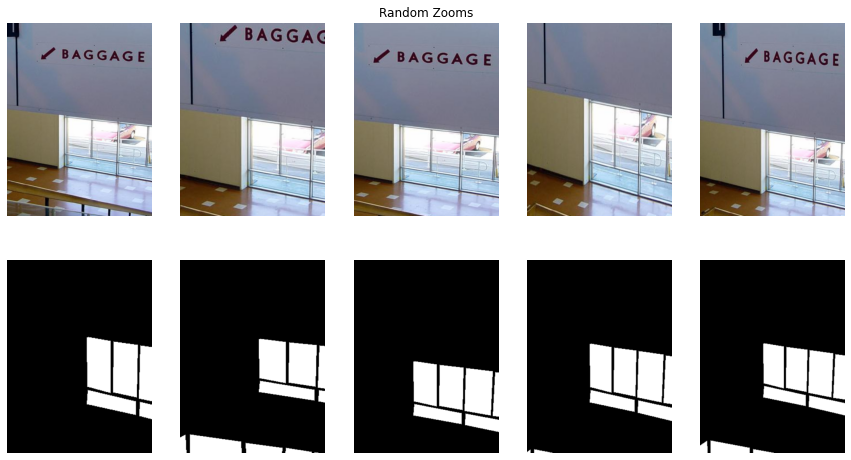

In [15]:
# Load a test image and corresponding mask
test_img_path = "test_image.jpg"
test_mask_path = "test_mask.png"
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_mask = cv2.imread(test_mask_path)
test_mask = test_mask[:,:,0]

# Define plots
fig, axs = plt.subplots(2, 5, figsize=(15,8))
axs[0,2].set_title('Random Zooms')

# Show five example transformations
for i in range(5):
    # Image Aug method
    axs[0,i].imshow(RandomZoomMask(test_img))
    axs[0,i].axis("off")
    axs[1,i].imshow(RandomZoomMask(test_mask), cmap='gray')
    axs[1,i].axis("off")

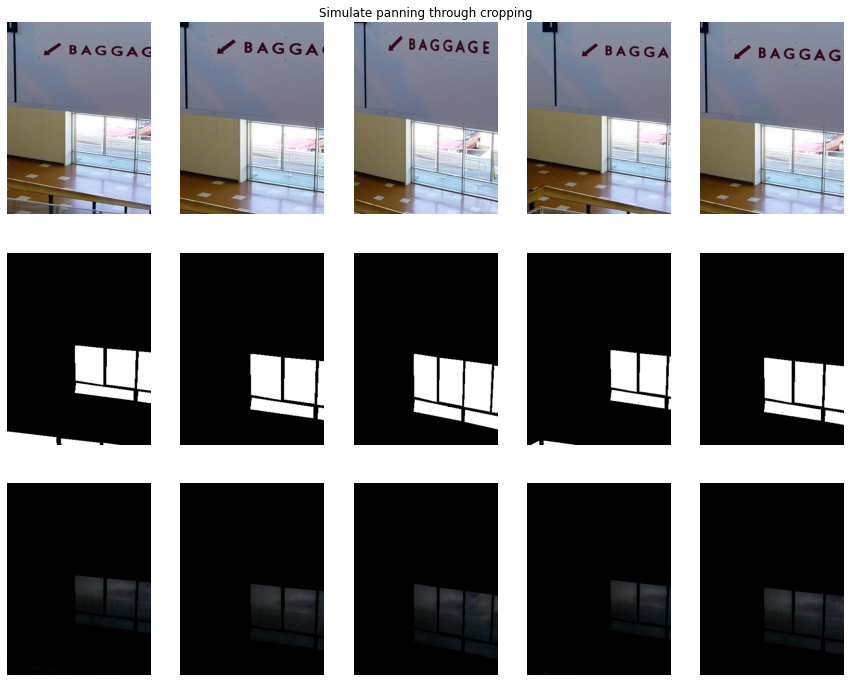

In [16]:
# Load a test image, corresponding mask and corresponding isolated reflection
test_img_path = "test_image.jpg"
test_mask_path = "test_mask.png"
test_ref_path = "test_ref.png"
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_mask = cv2.imread(test_mask_path)
test_mask = test_mask[:,:,0]
test_ref = cv2.imread(test_ref_path)
test_ref = cv2.cvtColor(test_ref, cv2.COLOR_BGR2RGB)

# Define plots
fig, axs = plt.subplots(3, 5, figsize=(15,12))
axs[0,2].set_title('Simulate panning through cropping')

# Show five example transformations
for i in range(5):
    # Run random panning method
    img, mask, reflection = RandomZoomImage(test_img, test_mask, test_ref)

    # Plot outputs
    axs[0,i].imshow(img)
    axs[0,i].axis("off")
    axs[1,i].imshow(mask, cmap='gray')
    axs[1,i].axis("off")
    axs[2,i].imshow(reflection)
    axs[2,i].axis("off")

In [17]:
def RandomPanMotion(img, mask, reflection):
    # Get image dimensions
    h,w,_ = img.shape

    # Augment mask for previous frame 
    s = 50
    x_start = random.randint(0, s) #int(np.abs(randOffset(s)))
    y_start = random.randint(0, s) #int(np.abs(randOffset(s)))
    x_end = random.randint(0, s) #int(np.abs(randOffset(s)))
    y_end = random.randint(0, s) #int(np.abs(randOffset(s)))
    mask_augmented = mask[y_start:h-y_end, x_start:w-x_end]

    # Pick a direction to shift the frame in (which direction will give the largest shift)
    randomDirection =  np.argmin([x_end, y_end, x_start, y_start])
    # Left
    if randomDirection == 0:
        x_end += x_start
        x_start = 0   
    # Up
    elif randomDirection == 1:
        y_end += y_start
        y_start = 0
    # Right
    elif randomDirection == 2:
        x_start += x_end
        x_end = 0
    # Down
    elif randomDirection == 3:
        y_start += y_end
        y_end = 0

    # Crop mask and image and reflection
    mask = mask[y_start:h-y_end, x_start:w-x_end]
    img = img[y_start:h-y_end, x_start:w-x_end, :]
    reflection = reflection[y_start:h-y_end, x_start:w-x_end, :]

    return img, mask, reflection, mask_augmented

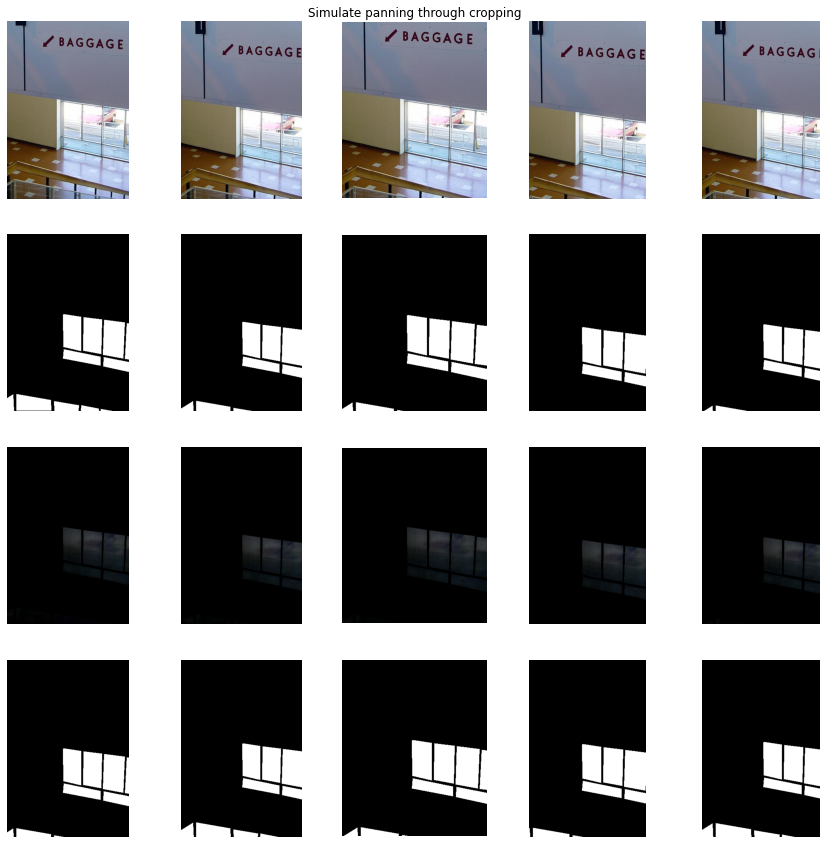

In [18]:
# Load a test image, corresponding mask and corresponding isolated reflection
test_img_path = "test_image.jpg"
test_mask_path = "test_mask.png"
test_ref_path = "test_ref.png"
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_mask = cv2.imread(test_mask_path)
test_mask = test_mask[:,:,0]
test_ref = cv2.imread(test_ref_path)
test_ref = cv2.cvtColor(test_ref, cv2.COLOR_BGR2RGB)

# Define plots
fig, axs = plt.subplots(4, 5, figsize=(15,15))
axs[0,2].set_title('Simulate panning through cropping')

# Show five example transformations
for i in range(5):
    # Run random panning method
    img, mask, reflection, mask_augmented = RandomPanMotion(test_img, test_mask, test_ref)

    # Plot outputs
    axs[0,i].imshow(img)
    axs[0,i].axis("off")
    axs[1,i].imshow(mask, cmap='gray')
    axs[1,i].axis("off")
    axs[2,i].imshow(reflection)
    axs[2,i].axis("off")
    axs[3,i].imshow(mask_augmented, cmap='gray')
    axs[3,i].axis("off")


## Major Transformations

Major transformations train the network to understand inadequate masks and discard them.  This can be achieved by mirroring the image in the horizontal and/or vertical axis.  This changes the structure of image fundementally and should thus train the network to ignore them.


In [19]:
# Uses imgaug library to to perform a minor perspective transform
def MajorTransformIA(img):
    # Random how the image is mirrored
    randomNum = np.random.randint(3)

    # Mirror image horizontally
    if randomNum % 2 == 0:
        img = flip.flipud(img)

    # Mirror image vertially   
    if randomNum > 0:
        img = flip.fliplr(img)

    return img

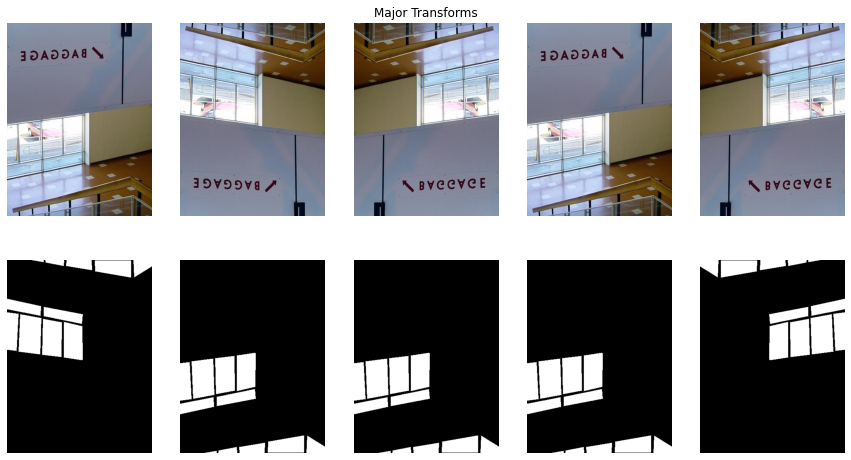

In [20]:
# Load a test image and corresponding mask
test_img_path = "test_image.jpg"
test_mask_path = "test_mask.png"
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_mask = cv2.imread(test_mask_path)
test_mask = test_mask[:,:,0]

# Define plots
fig, axs = plt.subplots(2, 5, figsize=(15,8))
axs[0,2].set_title('Major Transforms')

# Show five example transformations
for i in range(5):
    # Image Aug method
    axs[0,i].imshow(MajorTransformIA(test_img))
    axs[0,i].axis("off")
    axs[1,i].imshow(MajorTransformIA(test_mask), cmap='gray')
    axs[1,i].axis("off")


## Empty Masks

Trains the network to work correctly for the first frame and new objects in scene. This emulates the case of someone appearing in the camera's frame.  This mask is very simple.  It just contains all zeros.  A mask containing exclusivly ones can also be useful.

In [21]:
def EmptyMask(dims, also_full_masks=False):
    # Returns either a mask of all zeros or all ones
    if also_full_masks == True:
        return np.random.randint(2) * np.ones(dims)
    # Returns a mask with only zeros in it
    else:
        return np.ones(dims)


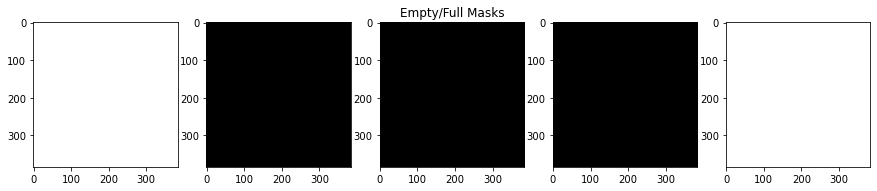

In [22]:
# Define plots
fig, axs = plt.subplots(1, 5, figsize=(15,8))
axs[2].set_title('Empty/Full Masks')

# Show five example transformations
for i in range(5):
    # Image Aug method
    axs[i].imshow(EmptyMask((384,384), True), vmin=0, vmax=1, cmap='gray')



##  Blurring Masks

Blurring masks could have several possible positive effects.  Firstly, it simiulates uncertainty in our mask channel.  Secondly, it can simulate motion blur.  There are more relistic way to generate motion blur which could be implmeneted at a later date.

See http://visual.cs.ucl.ac.uk/pubs/handlingMotionBlur/Improved_Handling_of_Motion_Blur_in_Online_Object_Detection_CVPR2021.pdf for more on motion blur.

In [23]:
# Apply simple Gaussian Blur (other type of blur exist in imgaug including motion blur)
# Sigma can a single value or a tuple specifying the range of sigmas to be used
def ApplyBlur(img, sig=(0.0, 8.0)):
    blur = iaa.GaussianBlur(sigma=sig)
    return blur(image=img)

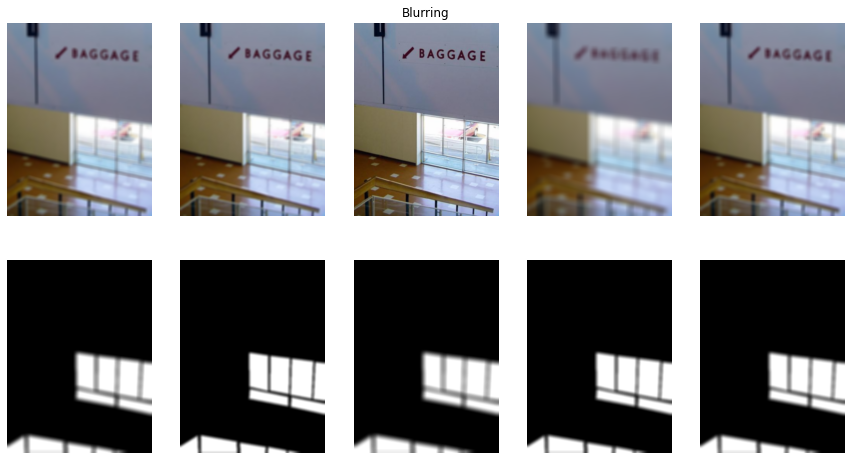

In [33]:
# Load a test image and corresponding mask
test_img_path = "test_image.jpg"
test_mask_path = "test_mask.png"
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_mask = cv2.imread(test_mask_path)
test_mask = test_mask[:,:,0]

# Define plots
fig, axs = plt.subplots(2, 5, figsize=(15,8))
axs[0,2].set_title('Blurring')

# Show five example transformations
for i in range(5):
    # Image Aug method
    axs[0,i].imshow(ApplyBlur(test_img))
    axs[0,i].axis("off")
    axs[1,i].imshow(ApplyBlur(test_mask), cmap='gray')
    axs[1,i].axis("off")

## Full Dataset Object

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


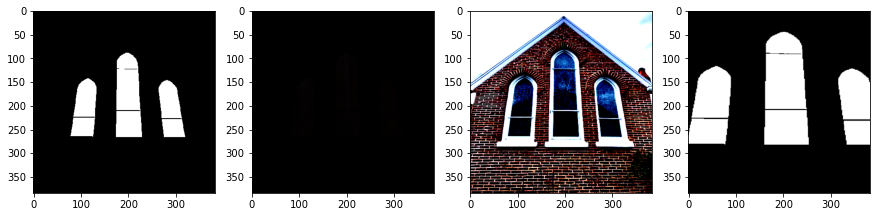

In [30]:
import numpy as np
import cv2
import random
from skimage import transform
from torch.utils.data import Dataset
import os
from imgaug import augmenters as iaa
import imgaug.augmenters.flip as flip

def ChangeColourSpace(img):
    # change the color space
    tmpImg = np.zeros((img.shape[0], img.shape[1], 3))
    img = img / np.max(img)
    if img.shape[2] == 1:
        tmpImg[:, :, 0] = (img[:, :, 0] - 0.485) / 0.229
        tmpImg[:, :, 1] = (img[:, :, 0] - 0.485) / 0.229
        tmpImg[:, :, 2] = (img[:, :, 0] - 0.485) / 0.229
    else:
        tmpImg[:, :, 0] = (img[:, :, 0] - 0.485) / 0.229
        tmpImg[:, :, 1] = (img[:, :, 1] - 0.456) / 0.224
        tmpImg[:, :, 2] = (img[:, :, 2] - 0.406) / 0.225
    return tmpImg

# Normalizes, scale and changes the dimension order for an RGD image
def PreProcessRGDImage(img):
    output_size = 384
    img = ChangeColourSpace(img)
    img = transform.resize(img, (output_size, output_size), mode='constant')
    img = np.transpose(img, (2, 0, 1))
    img = img[None, ...]
    img = img.astype(np.float32)
    return img

# Prepares a (red, green, blue, mask) input
def PreProcessRGDMImage(img, mask):
    # Recolour, resize and change dimensions
    output_size = 384
    img = ChangeColourSpace(img)
    img = transform.resize(img, (output_size, output_size), mode='constant')
    mask = transform.resize(mask, (output_size, output_size), mode='constant')
    img = np.transpose(img, (2, 0, 1))

    # stack rbg image with mask
    rgbm = np.zeros((1, 4, output_size, output_size))
    rgbm[0,:3,:,:] = img
    rgbm[0,3,:,:] = mask[:, :, 0]
    rgbm = rgbm.astype(np.float32)

    return rgbm


def Tensor2Img(tensor):
     return np.transpose(tensor[0,:,:,:].detach().numpy(), (1, 2, 0))

## Transformation functions
def RandomZoomMask(img):
    zoom = iaa.Crop(percent=(0, 0.25)) # random crop
    return zoom(image=img)

def RandomZoomImage(img, mask, ref):
    zoom = iaa.Crop(percent=(0, 0.25)) # random crop
    zoom = zoom.to_deterministic()
    return zoom(image=img), zoom(image=mask), zoom(image=ref)

# Uses imgaug library to to perform a minor perspective transform
def MinorTransformIA(img, lower=0.0, upper=0.1):
    persp = iaa.PerspectiveTransform(scale=(lower, upper), keep_size=True)
    return persp(image=img)

def RandomPanMotion(img, mask, reflection):
    # Get image dimensions
    h,w,_ = img.shape

    # Augment mask for previous frame 
    s = 50
    x_start = random.randint(0, s) #int(np.abs(randOffset(s)))
    y_start = random.randint(0, s) #int(np.abs(randOffset(s)))
    x_end = random.randint(0, s) #int(np.abs(randOffset(s)))
    y_end = random.randint(0, s) #int(np.abs(randOffset(s)))
    mask_augmented = mask[y_start:h-y_end, x_start:w-x_end]

    # Pick a direction to shift the frame in (which direction will give the largest shift)
    randomDirection =  np.argmin([x_end, y_end, x_start, y_start])
    # Left
    if randomDirection == 0:
        x_end += x_start
        x_start = 0   
    # Up
    elif randomDirection == 1:
        y_end += y_start
        y_start = 0
    # Right
    elif randomDirection == 2:
        x_start += x_end
        x_end = 0
    # Down
    elif randomDirection == 3:
        y_start += y_end
        y_end = 0

    # Crop mask and image and reflection
    mask = mask[y_start:h-y_end, x_start:w-x_end]
    img = img[y_start:h-y_end, x_start:w-x_end, :]
    reflection = reflection[y_start:h-y_end, x_start:w-x_end, :]

    return img, mask, reflection, mask_augmented

# Uses imgaug library to to perform a minor perspective transform
def MajorTransformIA(img):
    # Random how the image is mirrored
    randomNum = np.random.randint(3)

    # Mirror image horizontally
    if randomNum % 2 == 0:
        img = flip.flipud(img)

    # Mirror image vertially   
    if randomNum > 0:
        img = flip.fliplr(img)

    return img

def EmptyMask(dims, also_full_masks=False):
    # Returns either a mask of all zeros or all ones
    if also_full_masks == True:
        return np.random.randint(2) * np.ones(dims)
    # Returns a mask with only zeros in it
    else:
        return np.ones(dims)

# Sigma can a single value or a tuple specifying the range of sigmas to be used
def ApplyBlur(img, sig=(0.0, 8.0)):
    blur = iaa.GaussianBlur(sigma=sig)
    return blur(image=img)

class AugmentedGSD(Dataset):
    def __init__(self, training_path):
        self.img_path = training_path + "image/" 
        self.mask_path = training_path + "mask/" 
        self.reflections_path = training_path + "reflections/" 
        self.filenames = os.listdir(self.reflections_path)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        # Define path
        filename = self.filenames[idx]
        filename = filename[:-4]

        # Load image
        
        img = cv2.imread(str(self.img_path + str(filename) + ".jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load reflection image
        reflection = cv2.imread(str(self.reflections_path + str(filename) + ".png"))
        reflection = cv2.cvtColor(reflection, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(str(self.mask_path + str(filename) + ".png"))
        mask = mask[:,:,0]

        # Normalize mask
        if np.max(mask) < 1e-6:
            mask = mask
        else:
            mask = mask / np.max(mask)

        # Mirror half of the images
        mirror = random.randint(0, 1)
        if mirror == 1:
            img = flip.fliplr(img)
            mask = flip.fliplr(mask)
            reflection = flip.fliplr(reflection)

        # Randomize whether a minor homography is apply to the mask, major homography is applied to the mask, or an empty mask is used
        transformationType = 5
        output_size = 384   
        if transformationType in (0,1,2):
            mask_augmented = MinorTransformIA(mask)
        elif transformationType == 3:
            img, mask, reflection, mask_augmented = RandomPanMotion(img, mask, reflection)
        elif transformationType == 4:
            mask_augmented = mask
            img, mask, reflection = RandomZoomImage(img, mask, reflection)
        elif transformationType == 5:
            mask_augmented = RandomZoomMask(mask)
        elif transformationType in (6,7,8):
            mask_augmented = EmptyMask((output_size,output_size), True)
        elif transformationType in (9,10,11):
            mask_augmented = MajorTransformIA(mask)

        # Blur half of the masks
        mirror = random.randint(0, 1)
        if mirror == 1:
            mask_augmented = ApplyBlur(mask_augmented)
           
        # change the color space
        tmpImg = ChangeColourSpace(img)

        # Resize images
        img = transform.resize(tmpImg, (output_size, output_size), mode='constant')
        mask = transform.resize(mask, (output_size, output_size), mode='constant', order=0, preserve_range=True)
        mask_augmented = transform.resize(mask_augmented, (output_size, output_size), mode='constant', order=0, preserve_range=True)
        reflection = transform.resize(reflection, (output_size, output_size), mode='constant')

        # Stack the colour image with the augmented mask to create the input to the network
        stacked_img = np.zeros((output_size, output_size, 4))
        stacked_img[:,:,:3] = img
        stacked_img[:,:,3] = mask_augmented

        # Show images
        # Define plots
        fig, axs = plt.subplots(1, 4, figsize=(15,8))
        axs[0].imshow(mask, cmap='gray')
        axs[1].imshow(reflection)
        axs[2].imshow(stacked_img[:,:,:3])
        axs[3].imshow(stacked_img[:,:,3], cmap='gray')

        # Change dimensions to be PyTorch friendly
        stacked_img = np.transpose(stacked_img, (2, 0, 1))
        reflection = np.transpose(reflection, (2, 0, 1))

        return stacked_img, mask, reflection, transformationType


#dataset = AugmentedGSD("PATH TO GSD DATASET HERE")
#_,_,_,_ = dataset[0]
